In [27]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from math import sqrt as sq
import matplotlib.image as mpimg
import random
import cv2
import os
import time
from PIL import Image
import requests

In [20]:
# Settings
NUM_CLASSES = 43
INPUT_SHAPE = (32, 32, 3)
INP_SIZE = INPUT_SHAPE[0]
NUM_EPOCHS = 15
BATCH_SIZE = 128
seed = np.random.seed(42)

In [3]:
def assemble_data(data_folder='sign_data',
                  num_classes=NUM_CLASSES,
                  subset='train',
                  img_size=INPUT_SHAPE):
    
    """Dataset assemble from images"""
    
    value_string_template = '\033[91m[[value]]\033[0m'
    
    start_t = time.time()
    data = []
    labels = []
    cwd_path = os.getcwd()
    err_cnt = 0
    
    print(f"Data assembling \033[94mStarted\033[0m...")

    for i in range(num_classes):
        path = os.path.join(cwd_path, data_folder, 'train', str(i))
        images = os.listdir(path)

        for img_name in images:
            try:
                image = Image.open(path + '\\' + img_name)
                image = image.resize(img_size[:2]) # input img size with channels
                image = np.array(image)
                data.append(image)
                labels.append(i)
            except:
                err_cnt +=1
                print(f"Error during loading image: {path}")
    
    data = np.array(data)
    labels = np.array(labels)
    s_errs = value_string_template.replace('[[value]]', str(err_cnt))
    s_wtime = value_string_template.replace('[[value]]', str(round(time.time()- start_t, 2)))
    print(f"Data assembling \033[94mDone\033[0m Total errors: {s_errs}, Wall time: {s_wtime} s")
    
    return data, labels

In [4]:
# Get data
data, labels = assemble_data() # data.shape: (39209, 32, 32, 3)

Data assembling Started...
Data assembling Done Total errors: 0, Wall time: 115.96 s


In [5]:
# Принимает на вход список файлов, выводит матрицу изображений с метками с заданным размером
def plot_images_grid(data, labels, n_take):
    
    """
    Visualize random samples of data.
    
    Input:
    data: np.array like images list
    labels: np.array like labels list 
    n: number images to show
    """
    
    n_images = data.shape[0]
    samples_list = np.random.randint(low=0, high=n_images, size=n_take)
    plt.figure(figsize=(14,10))
    
    for i, sample in enumerate(samples_list):
        plt.subplot(sq(n_take)+1,sq(n_take),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data[sample, ...])
        plt.xlabel('class #' + str(labels[sample]))
    plt.show()

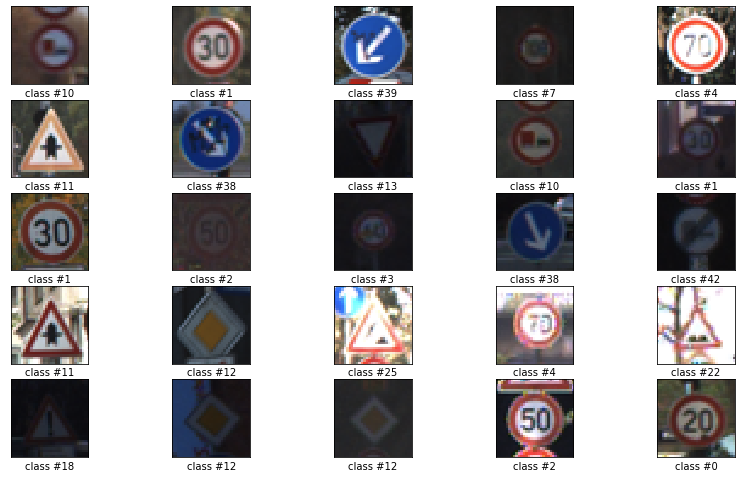

In [6]:
plot_images_grid(data, labels, n_take=25)

In [55]:
def prepare(img, label, n_class=NUM_CLASSES):
    
    img = img.reshape(-1, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2]).astype(np.float32) / 255.
    label = to_categorical(label, n_class) # label.reshape(-1).astype(np.int32) # onehot_label = tf.one_hot(label, n_class)
    
    return img, label

In [8]:
%%time

# Split data
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=seed)

X_train, y_train = prepare(X_train, y_train)
X_test, y_test = prepare(X_test, y_test)

# train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# train_ds = train_ds.shuffle(buffer_size=X_train.shape[0])
# train_ds = train_ds.repeat(NUM_EPOCHS)
# train_ds = train_ds.batch(BATCH_SIZE)

Wall time: 1.36 s


In [9]:
X_train.shape

(29406, 32, 32, 3)

In [10]:
def create_model():
    model = tf.keras.models.Sequential([
        keras.layers.Conv2D(6, (5, 5), activation='relu', padding='same', input_shape=INPUT_SHAPE),
        keras.layers.MaxPooling2D((2, 2), (2, 2)),
        keras.layers.Conv2D(16, (5, 5), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2), (2, 2)),
        keras.layers.Dropout(rate=0.25),
        keras.layers.Flatten(),
        keras.layers.Dense(120, activation='relu'),
        keras.layers.Dense(NUM_CLASSES, activation='softmax')])
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model
    
model = create_model()

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               1

In [12]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS,
                    validation_data=(X_test, y_test))

Train on 29406 samples, validate on 9803 samples
Epoch 1/15
29406/29406 [==============================] - 9s 314us/sample - loss: 2.0840 - accuracy: 0.4492 - val_loss: 0.8298 - val_accuracy: 0.7789
Epoch 2/15
29406/29406 [==============================] - 3s 111us/sample - loss: 0.6746 - accuracy: 0.8037 - val_loss: 0.4371 - val_accuracy: 0.8748
Epoch 3/15
29406/29406 [==============================] - 3s 111us/sample - loss: 0.3986 - accuracy: 0.8861 - val_loss: 0.2540 - val_accuracy: 0.9361
Epoch 4/15
29406/29406 [==============================] - 3s 111us/sample - loss: 0.2821 - accuracy: 0.9210 - val_loss: 0.1985 - val_accuracy: 0.9504
Epoch 5/15
29406/29406 [==============================] - 3s 112us/sample - loss: 0.2187 - accuracy: 0.9372 - val_loss: 0.1638 - val_accuracy: 0.9581
Epoch 6/15
29406/29406 [==============================] - 3s 112us/sample - loss: 0.1722 - accuracy: 0.9518 - val_loss: 0.1350 - val_accuracy: 0.9682
Epoch 7/15
29406/29406 [===========================

In [13]:
model.save('traffic_classifier.h5')